In [103]:
import pandas as pd
import subprocess
import re
import matplotlib.pyplot as plot

df = pd.read_excel('cacti_table.xls')

def getResults(results, regX):
    value = re.search(regX, results)
    if value:
        return value.group(1)
    return None

def getCactiInfo(df, param1, val1, param2, val2, target):
    row = df[(df[param1] == val1) & (df[param2] == val2) & (df[" Block Size(bytes)"] == 32)]
    if not row.empty:
        data = row[target].values[0]
        return data
    return None

In [104]:
compile = subprocess.run(["make"])
if compile.returncode != 0:
    print(f"Compilation Error : {compile.stderr}")


# Experiment 1 - L1 cache exploration: SIZE and ASSOC 
# For this experiment:
# BLOCKSIZE = 32
# L1 cache:
# SIZE is varied
# ASSOC is varied
# L2 cache: None
# Replacement policy: LRU 
# Inclusion property: non-inclusive  

blocksize = 32
l2Size = "0"
l2Assoc = "0"
policy = "0"
inclusion = "0"
trace = "traces/gcc_trace.txt"
missRates = []
AATs = []
xLabels = []

for i in range(1,12):
    xLabels.append(9+i)

for i in range(5): # 0 to 4
    l1Assoc = 2**i
    for j in range(1,12): # 1 to 11
        l1Size = 2**(9+j)
        if i == 4:
            l1Assoc = l1Size // blocksize
            outputFile = "".join(["ExpOutputs/Exp1/output_Assoc_Full_Size_", str(l1Size), ".txt"])
        else:
            outputFile = "".join(["ExpOutputs/Exp1/output_Assoc_", str(l1Assoc), "_Size_", str(l1Size), ".txt"])
        
        with open(outputFile, "w") as output:
            run = subprocess.run(["java", "sim_cache", str(blocksize), str(l1Size), str(l1Assoc), l2Size, l2Assoc, policy, inclusion, trace], stdout=output, stderr=subprocess.PIPE, text=True)
            if run.returncode != 0:
                print(f"Execution Error : {run.stderr}")

        with open(outputFile, "r") as output:
            results = output.read()

        if i != 4:
            ht = getCactiInfo(df, "Cache Size(bytes)", l1Size, " Associativity", l1Assoc, " Access Time(ns)")
        if i == 4 or ht == None:
            ht = getCactiInfo(df, "Cache Size(bytes)", l1Size, " Associativity", " FA", " Access Time(ns)")
        mr = float(getResults(results, "e. L1 miss rate:\s*([0-9.]+)"))
        missRates.append(mr)
        aat = ht + mr * 100
        AATs.append(aat)


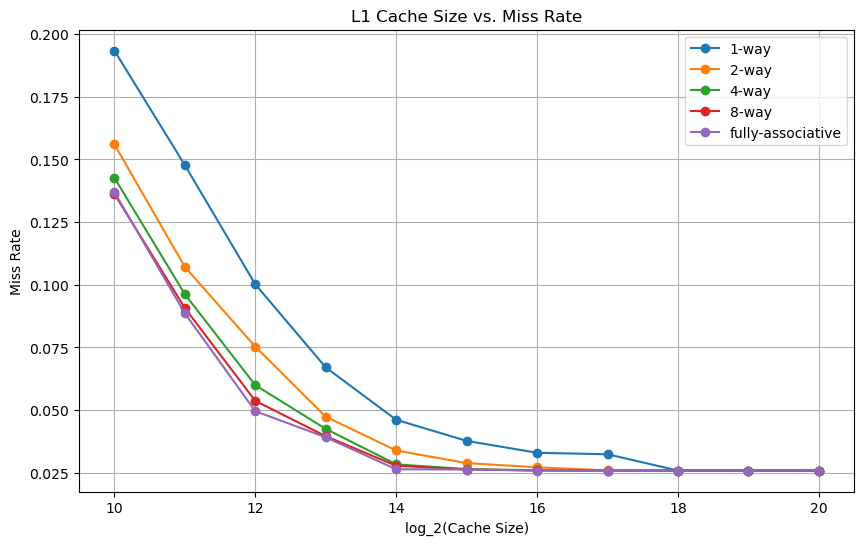

In [105]:
# GRAPH #1 (total number of simulations: 55)
# ================================================================
# Plot L1 miss rate on the y-axis versus log2(SIZE) on the x-axis, 
# for eleven different cache sizes: SIZE = 1KB, 2KB, ..., 1MB, in 
# powers-of-two. (That is, log2(SIZE) = 10, 11, ..., 20.) The graph 
# should contain five separate curves (i.e., lines connecting 
# points), one for each of the following associativities: 
# direct-mapped,  2-way  set-associative,  4-way  set-associative,  
# 8-way  set-associative,  and  fully-associative. All points for 
# direct-mapped caches should be connected with a line, all points 
# for 2-way set-associative caches should be connected with a line, 
# etc. 

plot.figure(figsize=(10,6))
missRateGroup = []

for i in range(5):
    assoc = 2**i
    if i != 4:
        label = f"{assoc}-way"
    else:
        label = "fully-associative"
    for j in range(11):
        missRateGroup.append(missRates[j + (i * 11)])
    plot.plot(xLabels, missRateGroup, label=label, marker='o')
    missRateGroup = []

plot.xlabel("log_2(Cache Size)")
plot.ylabel("Miss Rate")
plot.title("L1 Cache Size vs. Miss Rate")
plot.legend()
plot.grid(True)
plot.show()

## Discussion to include in your report: 
1. Discuss trends in the graph. For a given associativity, how does increasing cache size affect miss rate? For a given cache size, what is the effect of increasing associativity?
The data clearly show that as cache size is increased, cache miss rate decreases 
significantly. It is also deducible that increases in associativity also decrease cache miss 
rate. However, it must be noted that as cache size increases, the reduction in miss rate 
becomes less significant, and after 16KB (214), the effect becomes negligible for all 
cache sizes.
2. Estimate the compulsory miss rate from the graph.
The trends reveals that associativity plays a major role in compulsory miss reduction. 
All initial accesses are compulsory misses until a cache set is full; this means that with 
higher associativity, there is a higher likelihood that blocks will be mapped to the same 
set, and thus, once the set is full, will no longer contribute to compulsory misses. As 
such, it can be noted that higher associative caches plateau at the bottom of the graph 
earlier than lower associative caches, especially direct-mapped caches. At this plateau, 
caches are so large that the benchmark has a comparatively higher number of tags to map 
to each set, thereby decreasing the number of conflict misses to almost zero, and thus the 
miss rate consist almost entirely of compulsory misses with sufficiently high cache size. 
It seems the compulsory miss rate on this graph is roughly 0.025.
3. For each associativity, estimate the conflict miss rate from the graph.
It is known that fully associative caches have the lowest conflict miss rate, which we 
can treat as 0. The total miss rate for fully associative caches is virtually entirely due to 
compulsory misses; as such, for any given cache size, we can use the total miss rate from 
a fully associative cache of the same size to subtract out the compulsory miss rate (as it 
will be the same for any cache of the same size) from the miss rate of a cache with a 
lower associativity. For direct-mapped caches, the conflict miss rate is roughly 0.18−
0.1374=0.0425, for 2-way caches, it is 0.075−0.05=0.025, for 4-way, it is 
0.0625−0.05=0.0125, for 8-way, 0.14375−0.1375=0.00625, and for fully 
associative, it is 0.

## For memory hierarchy without L2 cache: 

# Total access time = (L1 reads + L1 writes) * HTL1 + (L1 read misses + L1 write misses) * Miss Penalty

# Average access time (AAT) = Total access time / (L1 reads + L1 writes) 

# AAT = HTL1 +  ((L1 read misses + L1 write misses) / (L1 reads + L1 writes)).Miss Penalty
 
# AAT = HTL1 + MRL1 * Miss Penalty

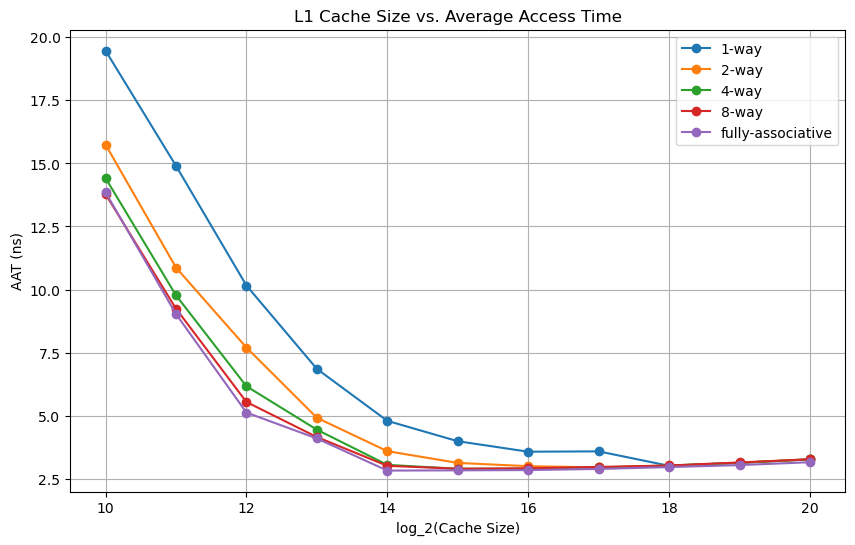

In [106]:
# GRAPH #2 (no additional simulations with respect to GRAPH #1)
# ================================================================
# Same as GRAPH #1, but the y-axis should be AAT instead of L1 miss 
# rate. 

plot.figure(figsize=(10,6))
AATGroup = []

for i in range(5):
    assoc = 2**i
    if i != 4:
        label = f"{assoc}-way"
    else:
        label = "fully-associative"
    for j in range(11):
        AATGroup.append(AATs[j + (i * 11)])
    plot.plot(xLabels, AATGroup, label=label, marker='o')
    AATGroup = []

plot.xlabel("log_2(Cache Size)")
plot.ylabel("AAT (ns)")
plot.title("L1 Cache Size vs. Average Access Time")
plot.legend()
plot.grid(True)
plot.show()

## Discussion to include in your report:
1. For a memory hierarchy with only an L1 cache and BLOCKSIZE = 32, which configuration yields the best (i.e., lowest) AAT?
Given the data, a cache size of 16KB (214) with full associativity is the optimal 
configuration to minimize average access time.

In [107]:
# Experiment 2 - Replacement policy study 
# For this experiment:
# BLOCKSIZE = 32
# L1 cache:
# SIZE is varied
# ASSOC = 4
# L2 cache: None
# Replacement policy: varied 
# Inclusion property: non-inclusive  

blocksize = 32
l1Assoc = "4"
l2Size = "0"
l2Assoc = "0"
inclusion = "0"
trace = "traces/gcc_trace.txt"
AATs = []
xLabels = []

for i in range(1,10):
    xLabels.append(9+i)

for i in range(3): # 0 to 2
    policy = str(i);
    for j in range(1,10): # 1 to 9
        l1Size = 2**(9+j)
        outputFile = "".join(["ExpOutputs/Exp2/output_Policy_", policy, "_Size_", str(l1Size), ".txt"])
        
        with open(outputFile, "w") as output:
            run = subprocess.run(["java", "sim_cache", str(blocksize), str(l1Size), str(l1Assoc), l2Size, l2Assoc, policy, inclusion, trace], stdout=output, stderr=subprocess.PIPE, text=True)
            if run.returncode != 0:
                print(f"Execution Error : {run.stderr}")

        with open(outputFile, "r") as output:
            results = output.read()

        ht = getCactiInfo(df, "Cache Size(bytes)", l1Size, " Associativity", "4", " Access Time(ns)")
        if ht == None:
            ht = getCactiInfo(df, "Cache Size(bytes)", l1Size, " Associativity", " FA", " Access Time(ns)")

        mr = float(getResults(results, "e. L1 miss rate:\s*([0-9.]+)"))

        aat = ht + mr * 100

        AATs.append(aat)

 

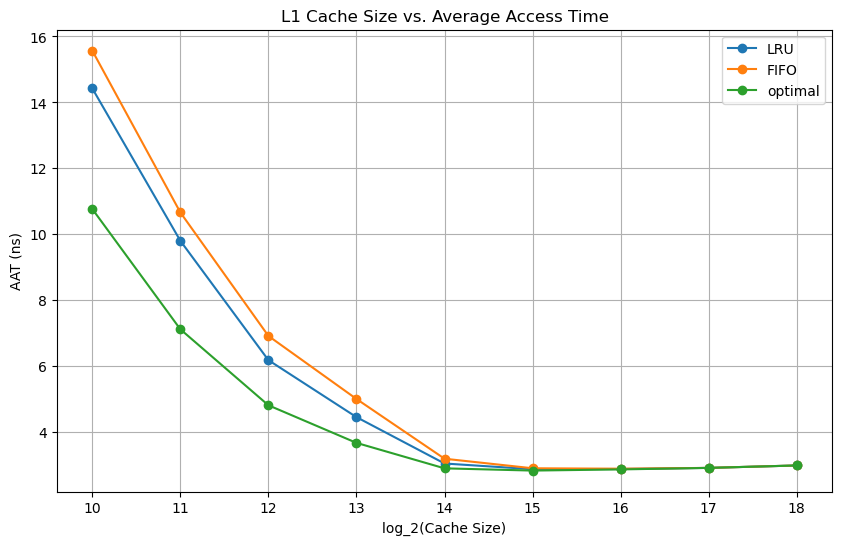

In [108]:
# GRAPH #3 (total number of simulations: 27) 
# ================================================================
# Plot AAT on the y-axis versus log2(SIZE) on the x-axis, for nine 
# different cache sizes: SIZE = 1KB, 2KB, ... , 256KB, in 
# powers-of-two. (That is, log2(SIZE) = 10, 11, ..., 18.) The graph 
# should contain three separate curves (i.e., lines connecting 
# points), one for each of the following replacement policies: LRU, 
# FIFO, optimal. All points for LRU replacement policy should be 
# connected with a line, all points for FIFO replacement policy 
# should be connected with a line, etc. 

plot.figure(figsize=(10,6))
AATGroup = []

for i in range(3):
    if i == 0:
        label = "LRU"
    elif i == 1:
        label = "FIFO"
    else:
        label = "optimal"
    for j in range(9):
        AATGroup.append(AATs[j + (i * 9)])
    plot.plot(xLabels, AATGroup, label=label, marker='o')
    AATGroup = []

plot.xlabel("log_2(Cache Size)")
plot.ylabel("AAT (ns)")
plot.title("L1 Cache Size vs. Average Access Time")
plot.legend()
plot.grid(True)
plot.show()

## Discussion to include in your report: 
1. Discuss trends in the graph. Which replacement policy yields the best (i.e., lowest) AAT?
It goes without saying that optimal replacement policy is, of course, optimal; 
however, since this policy is not implementable in practice, the data also show that LRU 
replacement is marginally better than FIFO in terms of AAT. The difference is relatively 
constant until 16KB (214), where the access times begin to converge at just under 3ns.

In [109]:
# Experiment 3 - Inclusion property study 
# For this experiment:
# BLOCKSIZE = 32
# L1 cache
# SIZE = 1KB
# ASSOC = 4
# L2 cache:
# SIZE = 2KB – 64KB
# ASSOC = 8
# BLOCKSIZE = 32
# Replacement policy: LRU 
# Inclusion property: varied  

blocksize = "32"
l1Size = "1024"
l1Assoc = "4"
l2Assoc = "8"
policy = "0"
trace = "traces/gcc_trace.txt"
AATs = []
xLabels = []

for i in range(2,8):
    xLabels.append(9+i)


for i in range(2): # 0 to 1
    inclusion = str(i);
    for j in range(2,8): # 1 to 7
        l2Size = 2**(9+j)
        outputFile = "".join(["ExpOutputs/Exp3/output_inclusion_", inclusion, "_Size_", str(l2Size), ".txt"])
        
        with open(outputFile, "w") as output:
            run = subprocess.run(["java", "sim_cache", blocksize, l1Size, l1Assoc, str(l2Size), l2Assoc, policy, inclusion, trace], stdout=output, stderr=subprocess.PIPE, text=True)
            if run.returncode != 0:
                print(f"Execution Error : {run.stderr}")

        with open(outputFile, "r") as output:
            results = output.read()

        htl2 = getCactiInfo(df, "Cache Size(bytes)", l2Size, " Associativity", "8", " Access Time(ns)")
        if htl2 == None:
            htl2 = getCactiInfo(df, "Cache Size(bytes)", l2Size, " Associativity", " FA", " Access Time(ns)")

        mrl1 = float(getResults(results, "e. L1 miss rate:\s*([0-9.]+)"))
        mrl2 = float(getResults(results, "k. L2 miss rate:\s*([0-9.]+)"))

        aat = 0.14682 + mrl1 * (htl2 + mrl2 * 100)

        AATs.append(aat)


## For memory hierarchy with L2 cache:

# AAT = HTL1 + ((L1 read misses + L1 write misses) / (L1 reads + L1 writes)) * HTL2 + (L2 read misses / (L1 reads + L1 writes)) * Miss Penalty

# AAT = HTL1 + MRL1 * (HTL2 + MRL2 * Miss Penalty)

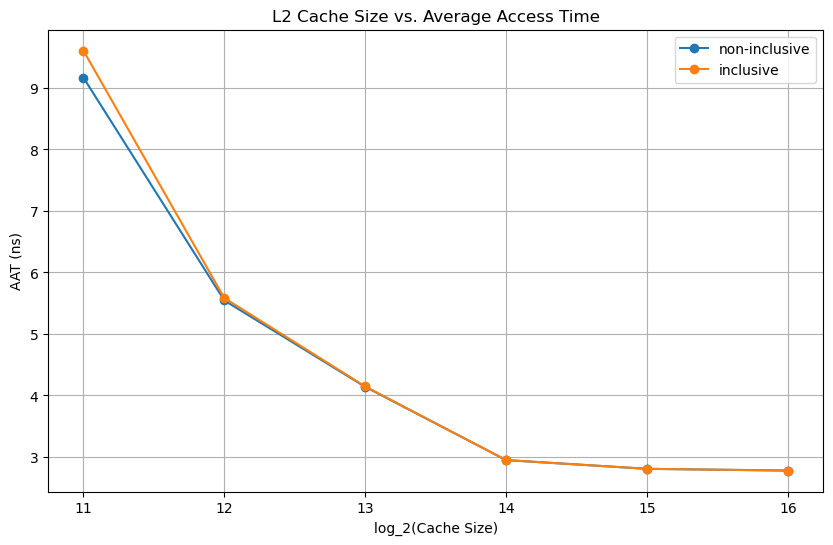

In [110]:
# GRAPH #4 (total number of simulations: 12)
# ================================================================
# Plot AAT on the y-axis versus log2(L2 SIZE) on the x-axis, for 
# six different L2 cache sizes: L2 SIZE = 2KB, 4KB, ... , 64KB, in 
# powers-of-two. (That is, log2(L2 SIZE) = 11, 12, ..., 16.) The 
# graph should contain two separate curves (i.e., lines 
# connecting points), one for each of the following inclusion 
# properties: non-inclusive and inclusive. All points for 
# non-inclusive cache should be connected with a line, all points 
# for inclusive cache should be connected with a line. 
 
plot.figure(figsize=(10,6))
AATGroup = []

for i in range(2):
    if i == 0:
        label = "non-inclusive"
    else:
        label = "inclusive"
    for j in range(6):
        AATGroup.append(AATs[j + (i * 6)])
    plot.plot(xLabels, AATGroup, label=label, marker='o')
    AATGroup = []

plot.xlabel("log_2(Cache Size)")
plot.ylabel("AAT (ns)")
plot.title("L2 Cache Size vs. Average Access Time")
plot.legend()
plot.grid(True)
plot.show()

## Discussion to include in your report:
1. Discuss trends in the graph. Which inclusion property yields a better (i.e., lower) AAT?
Both inclusion policies gave nearly identical results except for when the cache size 
was at its lowest. Naturally, a non-inclusive property should yield a lower average access 
time due to the absence of invalidations between caches. This is, however, clearly a 
negligible operation as it does not take much time to flip a single bit, and a write back to 
main memory is not always necessary. It should be noted that there is a known bug in the 
code used to produce this data where, when testing on the validation files, there was 
exactly one additional writeback and three sets where two blocks were inverted for L2 
cache only. While this bug could not be identified and fixed, the differences from the 
expected output were minute and did not affect AAT calculations. 